In [71]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay, DateOffset
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from flask import Flask, request, jsonify
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [146]:
class Arima():
    def __init__(self, ticker, show: bool = False, options: bool = False):
        df = self.setup(ticker, options)
        
        df = self.differencing(df, show)
        
        df, results = self.model(df, show, options)
        
        df = self.forecast(df, results)
        
        # return df
        
    def setup(self, ticker, options: bool = False):
        # Get stock data
        stock = yf.Ticker(ticker).history(period="10y")
        
        # Reset index to index rather than date
        stock = stock.reset_index()
        
        # Create new df with only date and close
        df = stock[['Date', 'Close']]
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
        df.set_index('Date', inplace=True)
        
        # Show descriptive statistics
        if options == True:
            df.describe().transpose()

        # Create time series
        time_series = df['Close']
        # type(time_series)
        
        if options == True:
            # Create rolling mean
            time_series.rolling(252).mean().plot(label='252 Day Rolling Mean')
            time_series.plot()
            
            # Create rolling std
            time_series.rolling(21).std().plot(label='21 Day Rolling STD')
            time_series.plot()
            
            plt.legend(['252 Day Rolling Mean', '21 Day Rolling STD'])
            plt.title('Time Series Analysis')
            
            # ETS Plot
            decomp = seasonal_decompose(time_series, period=12)
            decomp.plot()
            
        return df
            
    def differencing(self, df, show: bool = False):
        if show == True:
            # Differencing: first difference, change from one period to the next
            df['First Difference'] = df['Close'] - df['Close'].shift(1)
            df['First Difference'].plot()
            plt.title('First Difference')
            plt.xlabel('Year')
            plt.show()
            
            # Run it through ADF
            # adf_check(df['First Difference'].dropna())  # need to first value since we don't have it anymore

            # Second
            df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)
            # adf_check(df['Second Difference'].dropna())

            df['Second Difference'].plot()
            plt.title('Second Difference')
            plt.xlabel('Month')
            plt.show()
            
            # Seasonal
            df['Seasonal Difference'] = df['Close'] - df['Close'].shift(30)
            df['Seasonal Difference'].plot()
            plt.title('Seasonal Difference')
            plt.xlabel('Date')
            plt.show()

            # adf_check(df['Seasonal Difference'].dropna())
            
            # Seasonal First Difference
            df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(30)
            df['Seasonal First Difference'].plot()
            plt.title('Seasonal First Difference')
            plt.xlabel('Date')
            plt.show()

            self.adf_check(df['Seasonal First Difference'].dropna())
            
            return df
        
        if show == False:
            # Differencing: first difference, change from one period to the next
            df['First Difference'] = df['Close'] - df['Close'].shift(1)
            
            # Run it through ADF
            # adf_check(df['First Difference'].dropna())  # need to first value since we don't have it anymore

            # Second
            df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)
            # adf_check(df['Second Difference'].dropna())
            
            # Seasonal
            df['Seasonal Difference'] = df['Close'] - df['Close'].shift(30)
            # adf_check(df['Seasonal Difference'].dropna())
            
            # Seasonal First Difference
            df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(30)
            # self.adf_check(df['Seasonal First Difference'].dropna())
            
            return df  
          
    def adf_check(self, time_series):
        # Stationarity
        result = adfuller(time_series)
        
        print("Augmented Dicky-Fuller Test")
        labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of Observations Used']

        for value, label in zip(result, labels):
            print(label+" : "+str(value))

        if result[1] <= 0.05:
            print('Strong evidence against null hypothesis')
            print('reject null hypothesis')
            print('Data has no unit root and is stationary')

        else:
            print('Weak evidence against null hypothesis')
            print('Fail to reject null hypothesis')
            print('Data has a unit root and is non-stationary')
            
    def autocorrelation(self, df, show: bool = False):
        if show == True:
            # Autocorrelation Plots
            fig_first = plot_acf(df['First Difference'].dropna())        
            fig_seasonal_first = plot_acf(df['Seasonal First Difference'].dropna())

            autocorrelation_plot(df['Seasonal First Difference'].dropna())
            result = plot_pacf(df['Seasonal First Difference'].dropna())
            plot_pacf(df['Seasonal First Difference'].dropna())
            
        if show == False:
            pass
    
    def model(self, df, show: bool = False, options: bool = False):
        # Need frequency for SARIMA model
        df.index.freq = 'D' # may or may not need
        
        # seasonal arima model
        model = sm.tsa.arima.ARIMA(df['Close'], order=(0, 1, 0), seasonal_order=(0, 1, 0, 365))
        
        # Fit model to see results
        results = model.fit(method='innovations_mle', low_memory=True, cov_type='none')
        
        if options == True:
            results.summary()
        
        # Show plots and stats if true
        if show == True:
            results.resid.plot()
            results.resid.plot(kind='kde')
            
        return df, results
    
    def forecast(self, df, results):
        # Reset the index of df
        df.reset_index(drop=False, inplace=True)
        
        # Forecast Length
        start = len(df)
        end = round(len(df) + 252)  # TODO: Make dynamic
        
        # Forecasting Current
        df['forecast'] = results.predict(start=start, end=end)
        
        # Forecast future values, create and add time periods to do so
        start_date = df['Date'].max()
        # Create a CustomBusinessDay object to exclude weekends and holidays
        us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
        # Create future dates
        future_dates = pd.date_range(start_date, periods=252, freq=us_bd).strftime('%Y-%m-%d')  # TODO: Make dynamic period
        
        df.set_index('Date', inplace=True)

        # Create a future dates df
        future_df = pd.DataFrame(index=future_dates, columns=df.columns)
        future_df.index.name = 'Date'
        
        # Concatenate the original df with the future_df
        forecasted_df = pd.concat([df, future_df])
        forecasted_df.index.name = 'Date'
        
        forecasted_df.reset_index(inplace=True)
        
        forecasted_df['forecast'] = results.predict(start=start, end=end)
        
        return forecasted_df
    
    def plot_forecast(self, forecasted_df, df, ticker):
        # Plot
        forecasted_df[['Close', 'forecast']].plot(figsize=(12, 8))

        # # X limit
        plt.xlim((len(df) - 252), len(forecasted_df))

        # Add a grid with dotted lines
        plt.grid(linestyle='--')

        # Choose the number of evenly spaced ticks you want (e.g., 12)
        num_ticks = 12

        # Calculate tick positions
        tick_positions = np.linspace((len(df) - 252), (len(forecasted_df) - 1), num_ticks, dtype=int)

        # Get the corresponding dates for the tick positions
        tick_labels = forecasted_df.index[tick_positions]

        # Set the ticks and labels
        plt.xticks(tick_positions, tick_labels, rotation=45)  # Rotate labels for better visibility

        # Labels
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.title(f'Forecasted Price of {ticker}')
        plt.show()

# Set Up

In [137]:
def setup(ticker, options: bool = False):
    # Get stock data
    stock = yf.Ticker(ticker).history(period="10y")
    
    # Reset index to index rather than date
    stock = stock.reset_index()
    
    # Create new df with only date and close
    df = stock[['Date', 'Close']]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
    df.set_index('Date', inplace=True)
    
    # Show descriptive statistics
    if options == True:
        df.describe().transpose()

    # Create time series
    time_series = df['Close']
    # type(time_series)
    
    if options == True:
        # Create rolling mean
        time_series.rolling(252).mean().plot(label='252 Day Rolling Mean')
        time_series.plot()
        
        # Create rolling std
        time_series.rolling(21).std().plot(label='21 Day Rolling STD')
        time_series.plot()
        
        plt.legend(['252 Day Rolling Mean', '21 Day Rolling STD'])
        plt.title('Time Series Analysis')
        
        # ETS Plot
        decomp = seasonal_decompose(time_series, period=12)
        decomp.plot()
        
    return df

/var/folders/qb/w57f6h956gz_cvz4j8x7qwdm0000gn/T/ipykernel_96108/5401417.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date


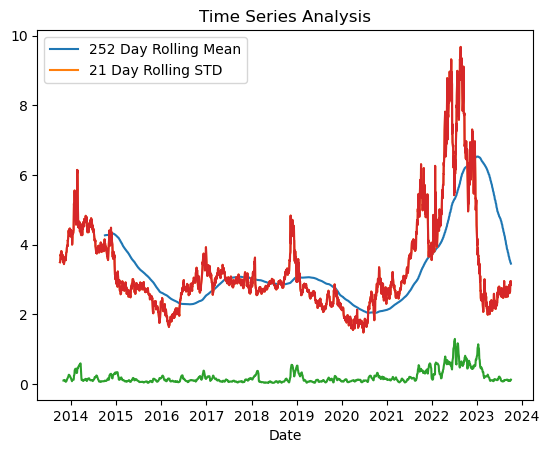

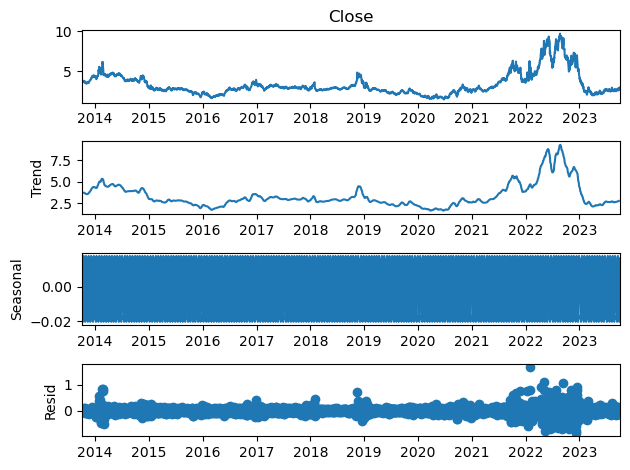

In [138]:
df = setup(ticker, options=True)

In [76]:
df

,Close
Date,
2013-10-03,3.499
2013-10-04,3.506
2013-10-07,3.629
2013-10-08,3.716
2013-10-09,3.679
...,...
2023-09-27,2.764
2023-09-28,2.945
2023-09-29,2.929


In [77]:
def adf_check(time_series):
    # Stationarity
    result = adfuller(time_series)
    
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of Observations Used']

    for value, label in zip(result, labels):
        print(label+" : "+str(value))

    if result[1] <= 0.05:
        print('Strong evidence against null hypothesis')
        print('reject null hypothesis')
        print('Data has no unit root and is stationary')

    else:
        print('Weak evidence against null hypothesis')
        print('Fail to reject null hypothesis')
        print('Data has a unit root and is non-stationary')

In [78]:
adf_check(df['Close'])

Augmented Dicky-Fuller Test
ADF Test Statistic : -2.634079614049221
p-value : 0.08615625370311619
# of lags : 23
Num of Observations Used : 2491
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non-stationary


# Differencing

In [79]:
def differencing(df, show: bool = False):
    if show == True:
        # Differencing: first difference, change from one period to the next
        df['First Difference'] = df['Close'] - df['Close'].shift(1)
        df['First Difference'].plot()
        plt.title('First Difference')
        plt.xlabel('Year')
        plt.show()
        
        # Run it through ADF
        # adf_check(df['First Difference'].dropna())  # need to first value since we don't have it anymore

        # Second
        df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)
        # adf_check(df['Second Difference'].dropna())

        df['Second Difference'].plot()
        plt.title('Second Difference')
        plt.xlabel('Month')
        plt.show()
        
        # Seasonal
        df['Seasonal Difference'] = df['Close'] - df['Close'].shift(30)
        df['Seasonal Difference'].plot()
        plt.title('Seasonal Difference')
        plt.xlabel('Date')
        plt.show()

        # adf_check(df['Seasonal Difference'].dropna())
        
        # Seasonal First Difference
        df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(30)
        df['Seasonal First Difference'].plot()
        plt.title('Seasonal First Difference')
        plt.xlabel('Date')
        plt.show()

        adf_check(df['Seasonal First Difference'].dropna())
        
        return df
    
    if show == False:
        # Differencing: first difference, change from one period to the next
        df['First Difference'] = df['Close'] - df['Close'].shift(1)
        
        # Run it through ADF
        # adf_check(df['First Difference'].dropna())  # need to first value since we don't have it anymore

        # Second
        df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)
        # adf_check(df['Second Difference'].dropna())
        
        # Seasonal
        df['Seasonal Difference'] = df['Close'] - df['Close'].shift(30)
        # adf_check(df['Seasonal Difference'].dropna())
        
        # Seasonal First Difference
        df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(30)
        adf_check(df['Seasonal First Difference'].dropna())
        
        return df       

In [80]:
differencing = differencing(df, show=False)

Augmented Dicky-Fuller Test
ADF Test Statistic : -10.438629420460016
p-value : 1.5427145512865841e-18
# of lags : 22
Num of Observations Used : 2461
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


# Autocorrelation

In [82]:
def autocorrelation(df):
    # Autocorrelation Plots
    fig_first = plot_acf(df['First Difference'].dropna())        
    fig_seasonal_first = plot_acf(df['Seasonal First Difference'].dropna())

    autocorrelation_plot(df['Seasonal First Difference'].dropna())
    result = plot_pacf(df['Seasonal First Difference'].dropna())
    plot_pacf(df['Seasonal First Difference'].dropna())

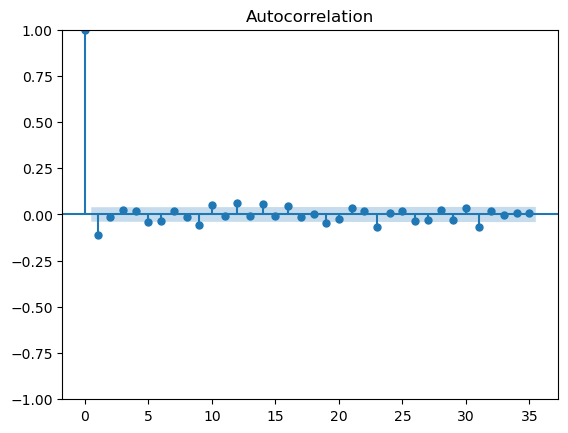

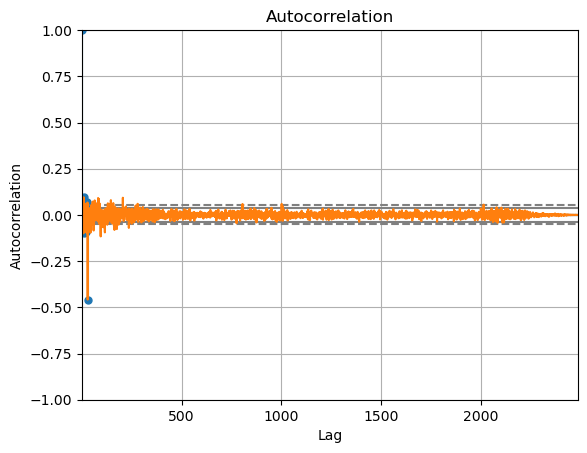

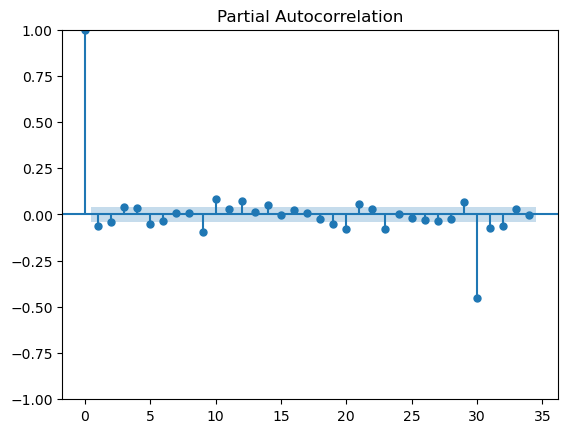

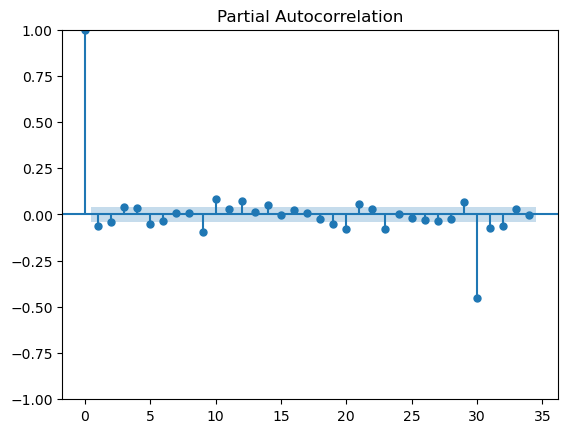

In [83]:
autocorrelation = autocorrelation(df)

order (p, d, q):
- p (Autoregressive Order): This parameter represents the number of autoregressive (AR) terms in the model. It indicates how many lag observations of the dependent variable should be included in the model.
- d (Integration Order): This parameter represents the order of differencing needed to make the time series stationary. It indicates how many times differencing should be applied to the series to achieve stationarity.
- q (Moving Average Order): This parameter represents the number of moving average (MA) terms in the model. It indicates how many lagged forecast errors should be included in the model.


seasonal_order (P, D, Q, S):
- P (Seasonal Autoregressive Order): This parameter represents the number of seasonal autoregressive (SAR) terms in the model. It is similar to p, but it applies to the seasonal component.
- D (Seasonal Integration Order): This parameter represents the order of seasonal differencing needed to make the seasonal part of the time series stationary.
- Q (Seasonal Moving Average Order): This parameter represents the number of seasonal moving average (SMA) terms in the model.
- S (Seasonal Periodicity): This parameter specifies the number of time steps in a seasonal cycle (e.g., 12 for monthly data, 4 for quarterly data).

In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable. This function uses Gaussian kernels and includes automatic bandwidth determination.

# Model

In [85]:
def model(df, show: bool = False, options: bool = False):
    # Need frequency for SARIMA model
    df.index.freq = 'D' # may or may not need
    
    # seasonal arima model
    model = sm.tsa.arima.ARIMA(df['Close'], order=(0, 1, 0), seasonal_order=(0, 1, 0, 365))
    
    # Fit model to see results
    results = model.fit(method='innovations_mle', low_memory=True, cov_type='none')
    
    if options == True:
        results.summary()
    
    # Show plots and stats if true
    if show == True:
        results.resid.plot()
        results.resid.plot(kind='kde')
        
    return df, results
        

In [86]:
df, results = model(df, show=False, options=False)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method

In [87]:
df

,Close,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference
Date,,,,,
2013-10-03,3.499,NaN,NaN,NaN,NaN
2013-10-04,3.506,0.007,NaN,NaN,NaN
2013-10-07,3.629,0.123,0.116,NaN,NaN
2013-10-08,3.716,0.087,-0.036,NaN,NaN
2013-10-09,3.679,-0.037,-0.124,NaN,NaN
...,...,...,...,...,...
2023-09-27,2.764,0.108,0.091,0.105,0.244
2023-09-28,2.945,0.181,0.073,0.353,0.248
2023-09-29,2.929,-0.016,-0.197,0.308,-0.045


# Forecast

In [93]:
def forecast(df, results):
    # Reset the index of df
    df.reset_index(drop=False, inplace=True)
    
    # Forecast Length
    start = len(df)
    end = round(len(df) + 252)  # TODO: Make dynamic
    
    # Forecasting Current
    df['forecast'] = results.predict(start=start, end=end)
    
    # Forecast future values, create and add time periods to do so
    start_date = df['Date'].max()
    # Create a CustomBusinessDay object to exclude weekends and holidays
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    # Create future dates
    future_dates = pd.date_range(start_date, periods=252, freq=us_bd).strftime('%Y-%m-%d')  # TODO: Make dynamic period
    
    df.set_index('Date', inplace=True)

    # Create a future dates df
    future_df = pd.DataFrame(index=future_dates, columns=df.columns)
    future_df.index.name = 'Date'
    
    # Concatenate the original df with the future_df
    final_df = pd.concat([df, future_df])
    final_df.index.name = 'Date'
    
    final_df.reset_index(inplace=True)
    
    final_df['forecast'] = results.predict(start=start, end=end)
    
    return final_df

In [94]:
final_df = forecast(df, results)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [96]:
def plot_forecast(final_df, ticker):
    # Plot
    final_df[['Close', 'forecast']].plot(figsize=(12, 8))

    # # X limit
    plt.xlim((len(df) - 252), len(final_df))

    # Add a grid with dotted lines
    plt.grid(linestyle='--')

    # Choose the number of evenly spaced ticks you want (e.g., 12)
    num_ticks = 12

    # Calculate tick positions
    tick_positions = np.linspace((len(df) - 252), (len(final_df) - 1), num_ticks, dtype=int)

    # Get the corresponding dates for the tick positions
    tick_labels = final_df.index[tick_positions]

    # Set the ticks and labels
    plt.xticks(tick_positions, tick_labels, rotation=45)  # Rotate labels for better visibility

    # Labels
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title(f'Forecasted Price of {ticker}')
    plt.show()

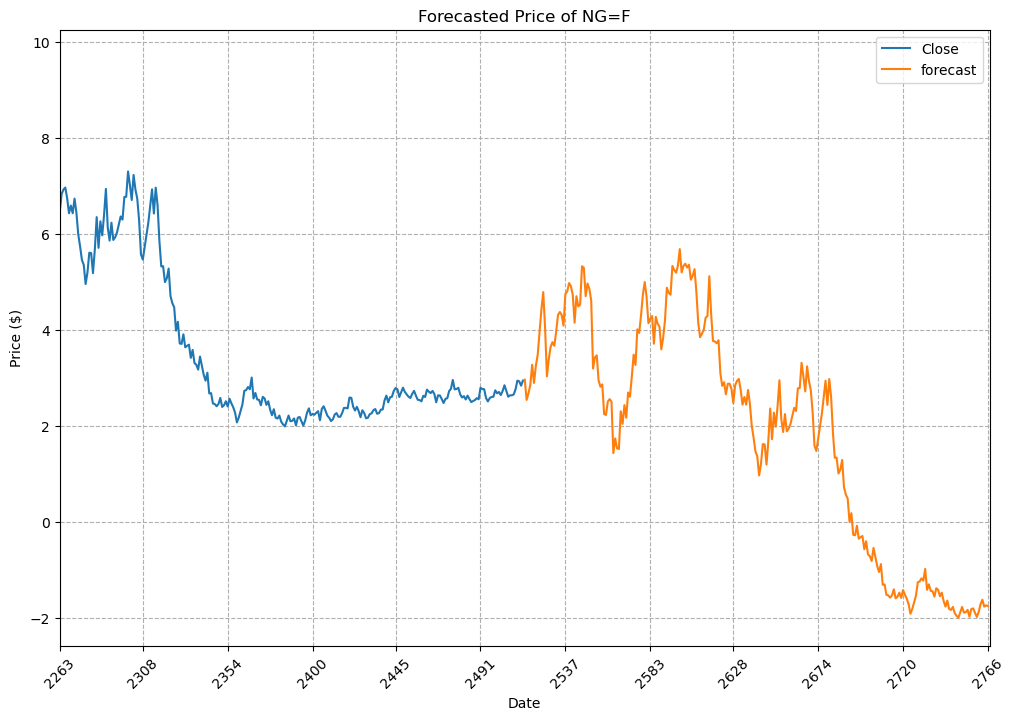

In [98]:
plot_forecast(final_df, ticker)

# Testing

In [149]:
ticker = 'NG=F'
arima = Arima(ticker, show=False, options=False)

/var/folders/qb/w57f6h956gz_cvz4j8x7qwdm0000gn/T/ipykernel_96108/3887599047.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python

In [154]:
arima

In [155]:
data = pd.DataFrame(arima)

ValueError: DataFrame constructor not properly called!

In [ ]:
d